# Search arout Fors2 region inside astroquery catalogs or image


- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : 2023/05/17
- last update : 2023-06-09
- FORS2 : https://github.com/ericnuss/fors2
- Result of StarLight : /sps/lsst/groups/photoz/fors2/FORS2/ResStarlight



          /Users/dagoret/MacOSX/GitHub/LSST/FORS2>ls -l
              total 0
              drwxrwsr-x  3 dagoret  staff   96 Aug 21  2018 ResStarlight
              drwxr-xr-x  9 dagoret  staff  288 Dec 19 18:01 fors2

https://astroquery.readthedocs.io/en/latest/

## Import

In [1]:
import os,sys,re
import h5py
from astropy.table import Table
import random

from astropy import coordinates
from astropy import units as u
from astropy.coordinates import Angle
from astroquery.skyview import SkyViewClass
from astropy.coordinates import SkyCoord
from astroquery.skyview import *
# https://astroquery.readthedocs.io/en/latest/api/astroquery.skyview.SkyViewClass.html

from astropy.wcs import WCS

from astroquery.sdss.core import SDSS
from astropy import coordinates as coords

In [2]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline
import pandas as pd
from itertools import cycle, islice


In [3]:
from scipy import ndimage

#from scipy import interp as scinterp
from scipy.interpolate import interp1d

import glob
import collections
#from def_raw_seds import *

In [4]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)

In [5]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [6]:
def GetColumnHfData(hff,list_of_keys,nameval):
    """
    Extract hff atttribute 
    
    parameters
      hff           : descriptor of h5 file
      list_of_keys : list of exposures
      nameval      : name of the attribute
      
    return
           the array of values in the order of 
    """
    

    all_data = []
    for key in list_of_keys:
        group=hff.get(key)
        val=group.attrs[nameval]
        all_data.append(val)
    return all_data


In [7]:
def ReadFors2h5FileAttributes(hf):
    hf =  h5py.File(input_file_h5, 'r') 
    list_of_keys = list(hf.keys())
    # pick one key    
    key_sel =  list_of_keys[0]
    # pick one group
    group = hf.get(key_sel)  
    #pickup all attribute names
    all_subgroup_keys = []
    for k in group.attrs.keys():
        all_subgroup_keys.append(k)
    # create info
    df_info = pd.DataFrame()
    for key in all_subgroup_keys:
        arr=GetColumnHfData(hf, list_of_keys ,key)
        df_info[key] = arr
    df_info.sort_values(by="num", ascending=True,inplace=True)
    df_info_num = df_info["num"].values
    key_tags = [ f"SPEC{num}" for num in df_info_num ]
    df_info["name"] = key_tags
    
    #'Nsp', 'RT', 'RV', 'Rmag', 'dec', 'eRV', 'lines', 'num', 'ra', 'redshift',
    
    df_info = df_info[['num' ,'name', 'ra', 'dec', 'Rmag','redshift','lines','RT','RV','eRV','Nsp']]
    return df_info
    

In [8]:
WL_BALMER_BREAK= 3646.0 
NQUANTILES = 10
quantiles = np.linspace(0,1,NQUANTILES+1)
quantiles

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [9]:
FLAG_REMOVE_RMAG0 = False

In [10]:
input_file_h5  = 'data/FORS2spectra.hdf5'

## Start

In [11]:
cwd=os.path.abspath("")
main_dir = cwd
print(f"notebook current executing path : {cwd}")

notebook current executing path : /Volumes/Backup2020/MacOSX/GitHub/LSST/PhotoZ_PhD/QueryCatalogs


## READ file

In [12]:
hf =  h5py.File(input_file_h5, 'r') 
list_of_keys = list(hf.keys())

In [13]:
df_info = ReadFors2h5FileAttributes(hf)

In [14]:
df_info.sort_values(by="num", ascending=True,inplace=True)

In [15]:
df_info.reset_index(drop=True, inplace=True) 

In [16]:
df_info_num = df_info["num"].values

In [17]:
key_tags = [ f"SPEC{num}" for num in df_info_num ]

### Get dataset

- wavelength and flux

In [18]:
all_df = []   
idx=0
for key in key_tags :
    group = hf.get(key)
    df = pd.DataFrame()
    df["wl"] = np.array(group.get("wl"))
    df["fl"] = np.array(group.get("fl")) 
    all_df.append(df)
    idx+=1

Text(0, 0.5, 'flux (maggies)')

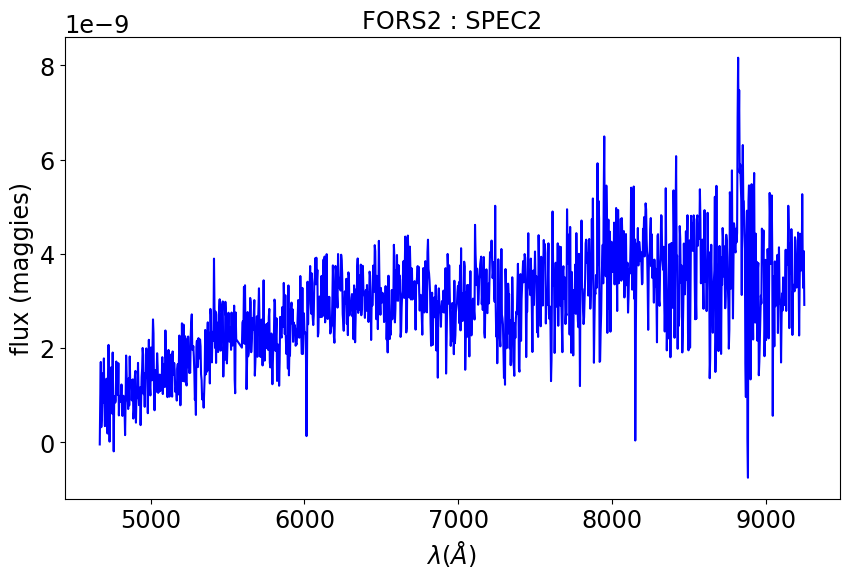

In [19]:
idx=0
fig = plt.figure(figsize=(10,6))
ax=fig.add_subplot(1,1,1)
ax.plot(all_df[idx]["wl"], all_df[idx]["fl"],'b-')
ax.set_xlabel("$\lambda  (\AA)$ ")
title = f"FORS2 : {key_tags[idx]}"
ax.set_title(title)
ax.set_ylabel("flux (maggies)")

# Plots

## Position of SL galaxies vs redshifts

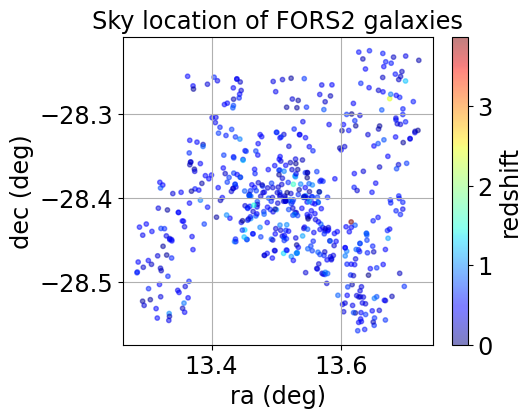

In [20]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
#im = ax.scatter(all_ra,all_dec,c=all_colors2,s=10,marker="o",alpha=0.5,cmap=jet2)
im = ax.scatter(df_info.ra,df_info.dec,c=df_info.redshift,s=10,marker="o",alpha=0.5,cmap="jet")
ax.grid()
ax.set_xlabel("ra (deg)")
ax.set_ylabel("dec (deg)")
ax.set_title("Sky location of FORS2 galaxies")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('redshift')

## Position vs Redshift

Text(0.5, 0.98, 'redshift')

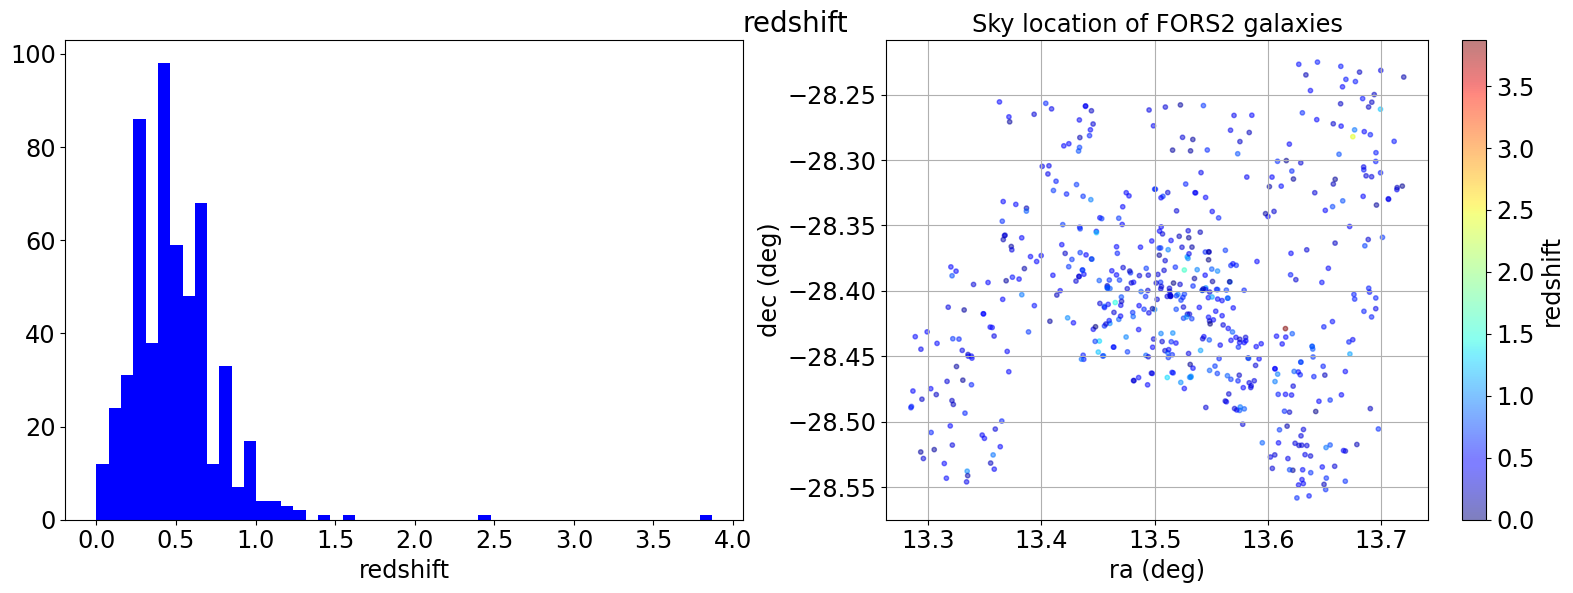

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(df_info.redshift,bins=50,facecolor="b");
        ax.set_xlabel("redshift")
    else:
        im = ax.scatter(df_info.ra,df_info.dec,c=df_info.redshift,s=10,marker="o",alpha=0.5,cmap="jet")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('redshift')
        ax.grid()
        ax.set_xlabel("ra (deg)")
        ax.set_ylabel("dec (deg)")
        ax.set_title("Sky location of FORS2 galaxies")
        #fig.colorbar(im, ax=ax)
plt.tight_layout()  
plt.suptitle("redshift",fontsize=20)

In [22]:
index_selected=np.where(df_info.redshift<1)[0]

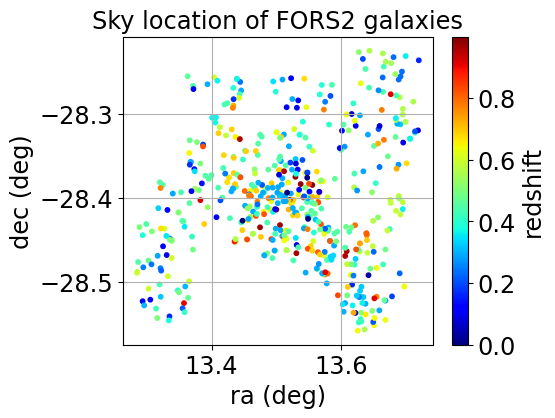

In [23]:
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
#im = ax.scatter(all_ra,all_dec,c=all_colors2,s=10,marker="o",alpha=0.5,cmap=jet2)
im = ax.scatter(df_info.ra.iloc[index_selected],df_info.dec.iloc[index_selected],c=df_info.redshift.iloc[index_selected],s=10,marker="o",alpha=1,cmap="jet")
ax.grid()
ax.set_xlabel("ra (deg)")
ax.set_ylabel("dec (deg)")
ax.set_title("Sky location of FORS2 galaxies")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('redshift')

# Plot on celestial maps
https://learn.astropy.org/tutorials/plot-catalog.html

In [24]:
gal_long = np.linspace(-180.,180,360)
gal_lat = np.zeros((360))

In [25]:
coordinates_galactic_planes = SkyCoord(l=gal_long*u.degree, b=gal_lat*u.degree, frame='galactic')
gp_radec = coordinates_galactic_planes.transform_to('icrs')  

### Fors2 spectra coordinates

In [26]:
ra_toplot = coordinates.Angle(df_info.ra.iloc[index_selected].values*u.degree)
ra_toplot = ra_toplot.wrap_at(180*u.degree)
dec_toplot = coordinates.Angle(df_info.dec.iloc[index_selected].values*u.degree)
redshifts_toplot = df_info.redshift.iloc[index_selected]

### Galactic plane coordinates

In [27]:
gp_ra_toplot = coordinates.Angle(gp_radec.ra.degree*u.degree)
gp_ra_toplot = gp_ra_toplot.wrap_at(180*u.degree)

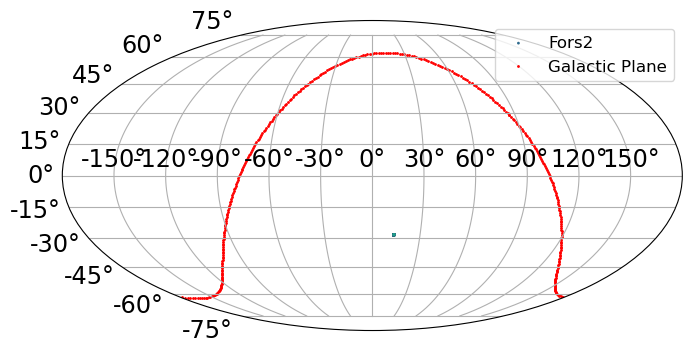

In [67]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_toplot.radian, dec_toplot.radian,c=redshifts_toplot,label="Fors2",s=1)
ax.scatter(gp_ra_toplot.radian, gp_radec.dec.radian,c="r",label="Galactic Plane",s=1)
ax.grid()
ax.legend()

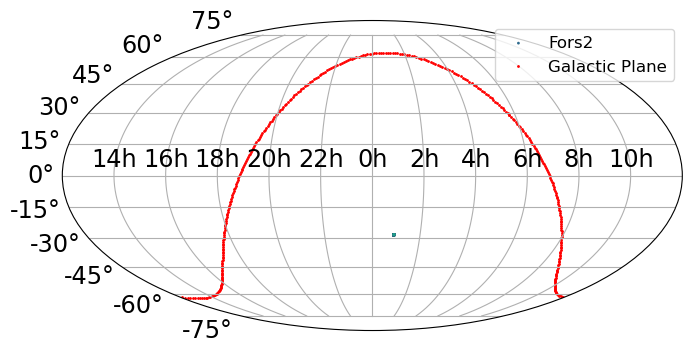

In [68]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection="mollweide")
ax.scatter(ra_toplot.radian, dec_toplot.radian,c=redshifts_toplot,label="Fors2",s=1)
ax.scatter(gp_ra_toplot.radian, gp_radec.dec.radian,c="r",label="Galactic Plane",s=1)
ax.set_xticklabels(['14h','16h','18h','20h','22h','0h','2h','4h','6h','8h','10h'])
ax.grid(True)
ax.legend()

# Position

In [30]:
df_info.describe()

num          ra         dec        Rmag    redshift          RT  \
count  550.000000  550.000000  550.000000  550.000000  550.000000  550.000000   
mean   421.587273   13.522065  -28.401811   19.889582    0.498955    9.546182   
std    199.222145    0.106640    0.074924    5.460220    0.295175    6.732525   
min      2.000000   13.284950  -28.558010    0.000000   -0.000600    0.000000   
25%    277.250000   13.450487  -28.451390   20.420000    0.294165    5.325000   
50%    433.000000   13.526855  -28.404395   21.190000    0.448555    8.450000   
75%    589.750000   13.608923  -28.355698   22.020000    0.632458   13.200000   
max    738.000000   13.719840  -28.225270   24.790000    3.869680   46.000000   

                 RV          eRV         Nsp  
count  5.500000e+02   550.000000  550.000000  
mean   1.359493e+05    91.572727    1.045455  
std    9.217559e+04   133.764362    0.262618  
min   -1.800000e+02     0.000000    1.000000  
25%    8.747250e+04    30.000000    1.000000  
50%    1.316595e+05    59.000000    1.000000  
75%    1.807305e+05   105.750000    1.000000  
max    1.160900e+06  1472.000000    4.000000

In [31]:
ra_angle = Angle(df_info.ra.mean(), u.deg)
dec_angle =  Angle(df_info.dec.mean(), u.deg)
ra_radius_std = Angle(df_info.ra.std(),u.deg)
dec_radius_std = Angle(df_info.dec.std(),u.deg)
ra_radius_minmax = Angle((df_info.ra.max()-df_info.ra.min())/2.,u.deg)
dec_radius_minmax = Angle((df_info.dec.max()-df_info.dec.min())/2.,u.deg)

In [32]:
ra_angle

<Angle 13.52206487 deg>

In [33]:
dec_angle

<Angle -28.40181098 deg>

In [34]:
ra_radius_minmax.arcmin

13.04669999999998

In [35]:
dec_radius_minmax.arcmin

9.982200000000034

## Position of galaxies vs Rmag

Text(0.5, 0.98, 'Rmag')

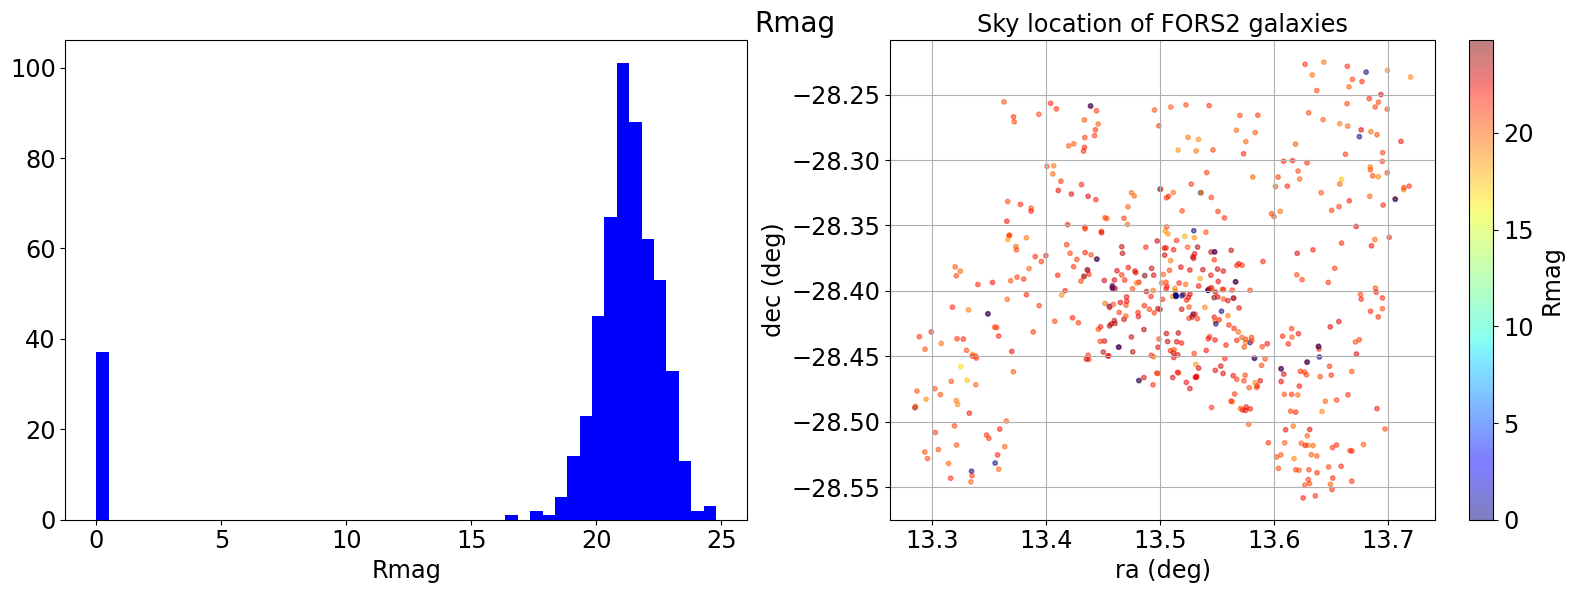

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
for idx, ax in enumerate(axes.flatten()):
    if idx == 0:
        ax.hist(df_info.Rmag,bins=50,facecolor="b");
        ax.set_xlabel("Rmag")
    else:
        im = ax.scatter(df_info.ra,df_info.dec,c=df_info.Rmag,s=10,marker="o",alpha=0.5,cmap="jet")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('Rmag')
        ax.grid()
        ax.set_xlabel("ra (deg)")
        ax.set_ylabel("dec (deg)")
        ax.set_title("Sky location of FORS2 galaxies")
        #fig.colorbar(im, ax=ax)
plt.tight_layout() 
plt.suptitle("Rmag",fontsize=20)

# In SkyView

https://astroquery.readthedocs.io/en/latest/skyview/skyview.html

In [37]:
SkyView.list_surveys() 

{'Allbands:GOODS/HDF/CDF': ['GOODS: Chandra ACIS HB',
                            'GOODS: Chandra ACIS FB',
                            'GOODS: Chandra ACIS SB',
                            'GOODS: VLT VIMOS U',
                            'GOODS: VLT VIMOS R',
                            'GOODS: HST ACS B',
                            'GOODS: HST ACS V',
                            'GOODS: HST ACS I',
                            'GOODS: HST ACS Z',
                            'Hawaii HDF U',
                            'Hawaii HDF B',
                            'Hawaii HDF V0201',
                            'Hawaii HDF V0401',
                            'Hawaii HDF R',
                            'Hawaii HDF I',
                            'Hawaii HDF z',
                            'Hawaii HDF HK',
                            'GOODS: HST NICMOS',
                            'GOODS: VLT ISAAC J',
                            'GOODS: VLT ISAAC H',
                            'GOODS: 

In [38]:
SkyView().get_image_list(position='RXJ0054.0-2823',survey=['DSS','GALEX Near UV','2MASS-J', '2MASS-H', '2MASS-K'])

['https://skyview.gsfc.nasa.gov/tempspace/fits/skv40558470655286_1.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv40558470655286_2.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv40558470655286_3.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv40558470655286_4.fits',
 'https://skyview.gsfc.nasa.gov/tempspace/fits/skv40558470655286_5.fits']

## DSS

In [39]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['DSS'],radius=0.5*u.deg)

In [40]:
the_img = all_img[0]

In [41]:
#the_img[0].header

In [42]:
wcs = WCS(the_img[0].header)

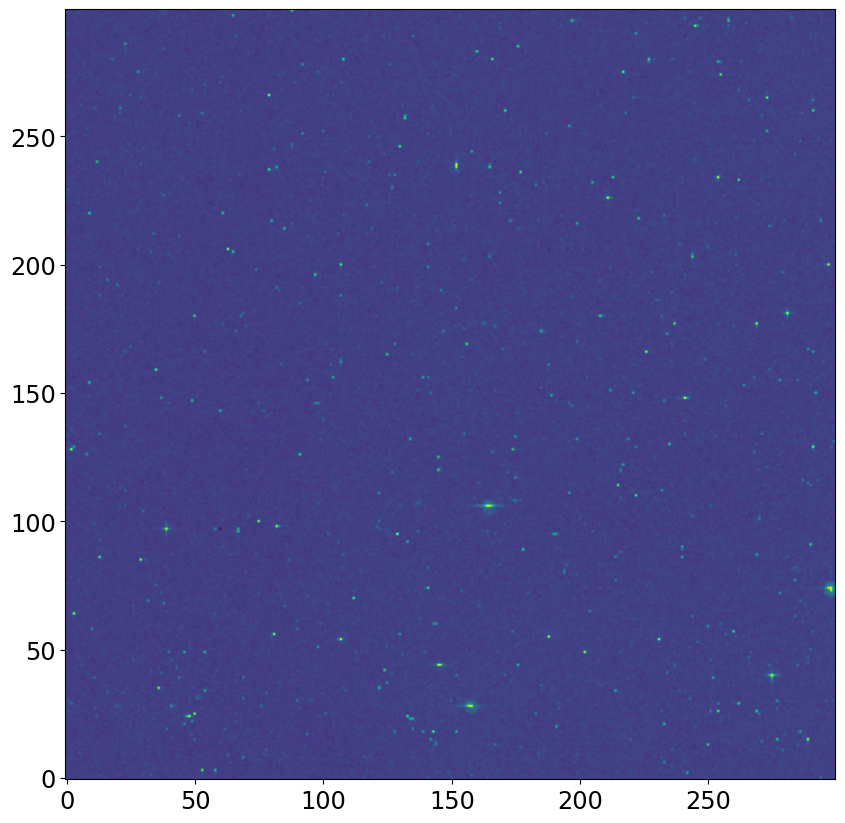

In [43]:
fig = plt.figure(figsize=(10,10))
#fig.set_figheight(15)
#fig.set_figwidth(15)
ax = fig.add_subplot(1,1,1)
ax.imshow(the_img[0].data,origin='lower')
plt.show()

Text(0.5, 1.0, 'DSS')

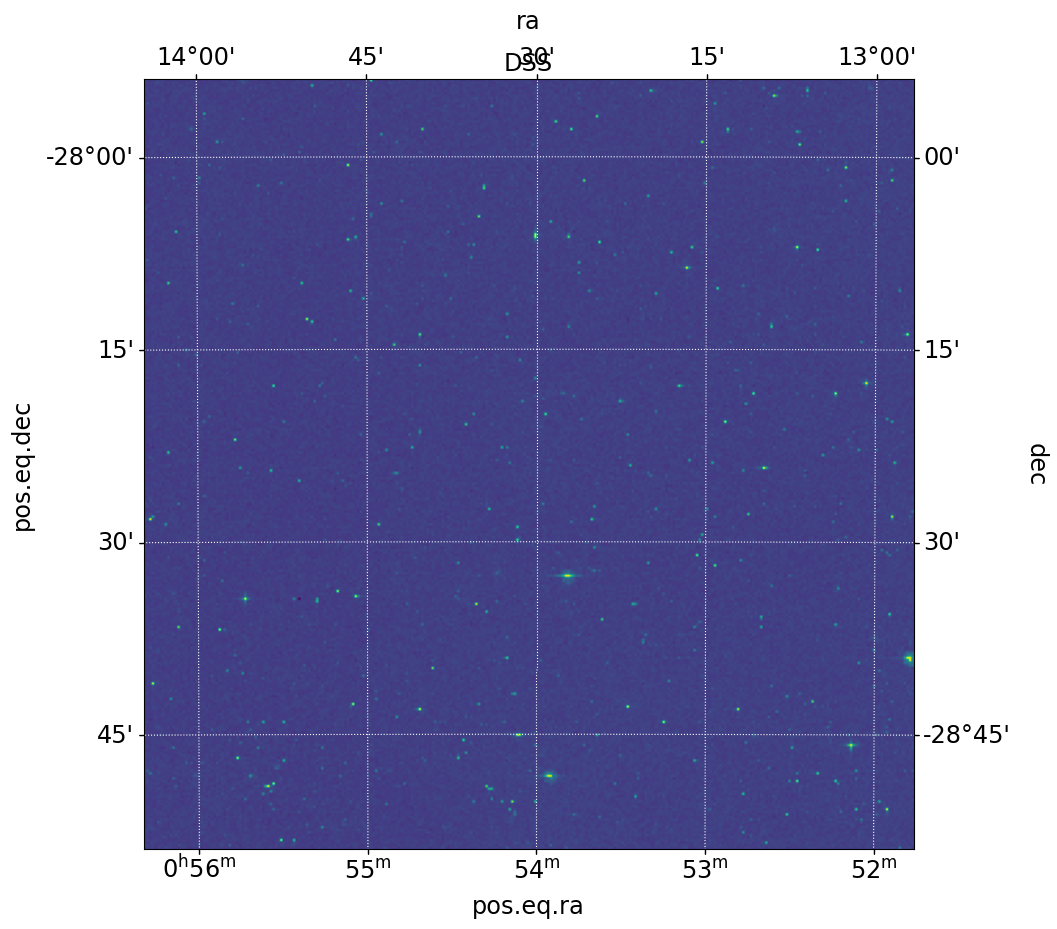

In [44]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
ax.set_title("DSS")

Text(0.5, 1.0, 'FORS2 and DSS')

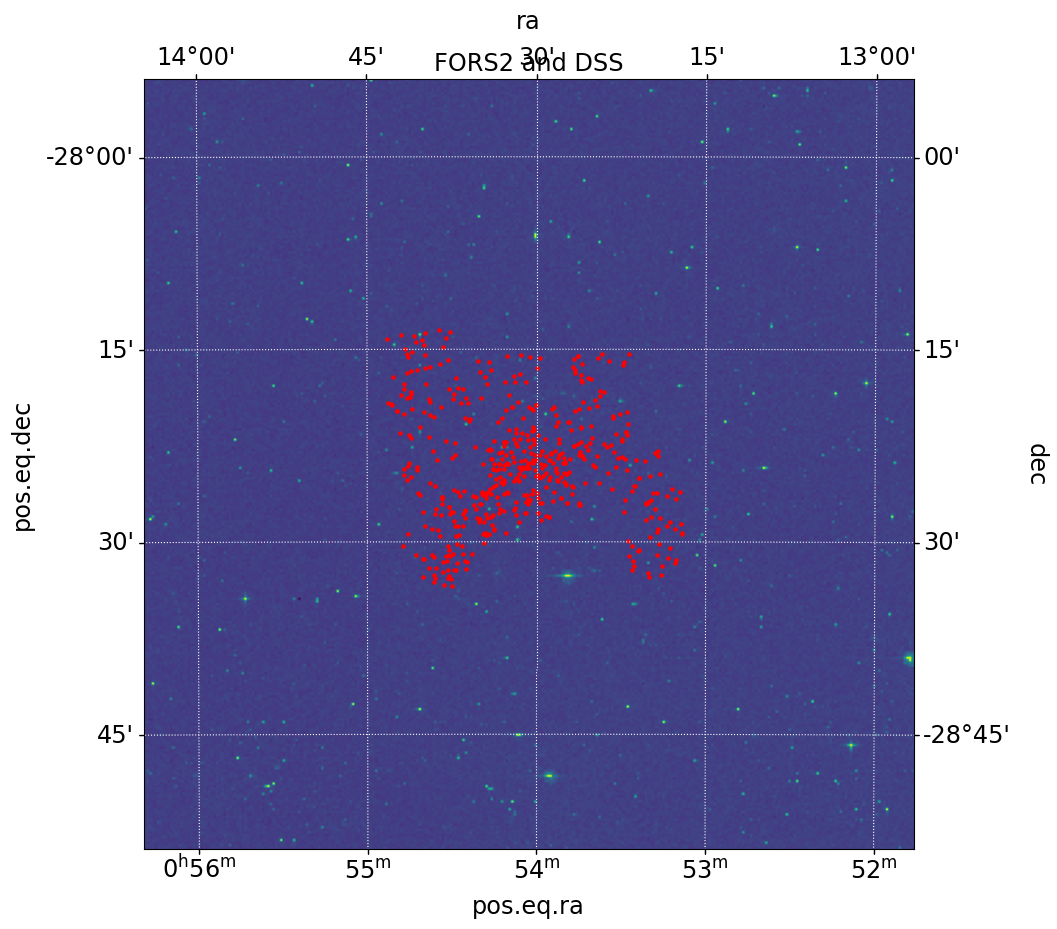

In [45]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower')
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=5)
ax.set_title("FORS2 and DSS")

## GALEX

In [46]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['GALEX Near UV'],radius=0.5*u.deg)
the_img = all_img[0]

In [47]:
wcs = WCS(the_img[0].header)

In [48]:
from astropy.visualization import (MinMaxInterval, SqrtStretch,ImageNormalize,ManualInterval, PercentileInterval, AsymmetricPercentileInterval,ZScaleInterval)
                        
from astropy.visualization.stretch import SinhStretch, LinearStretch,SqrtStretch,LogStretch
interval = ZScaleInterval()
transform = SqrtStretch() + ZScaleInterval()

from matplotlib.colors import LogNorm

norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())


Text(0.5, 1.0, 'GALEX Near UV')

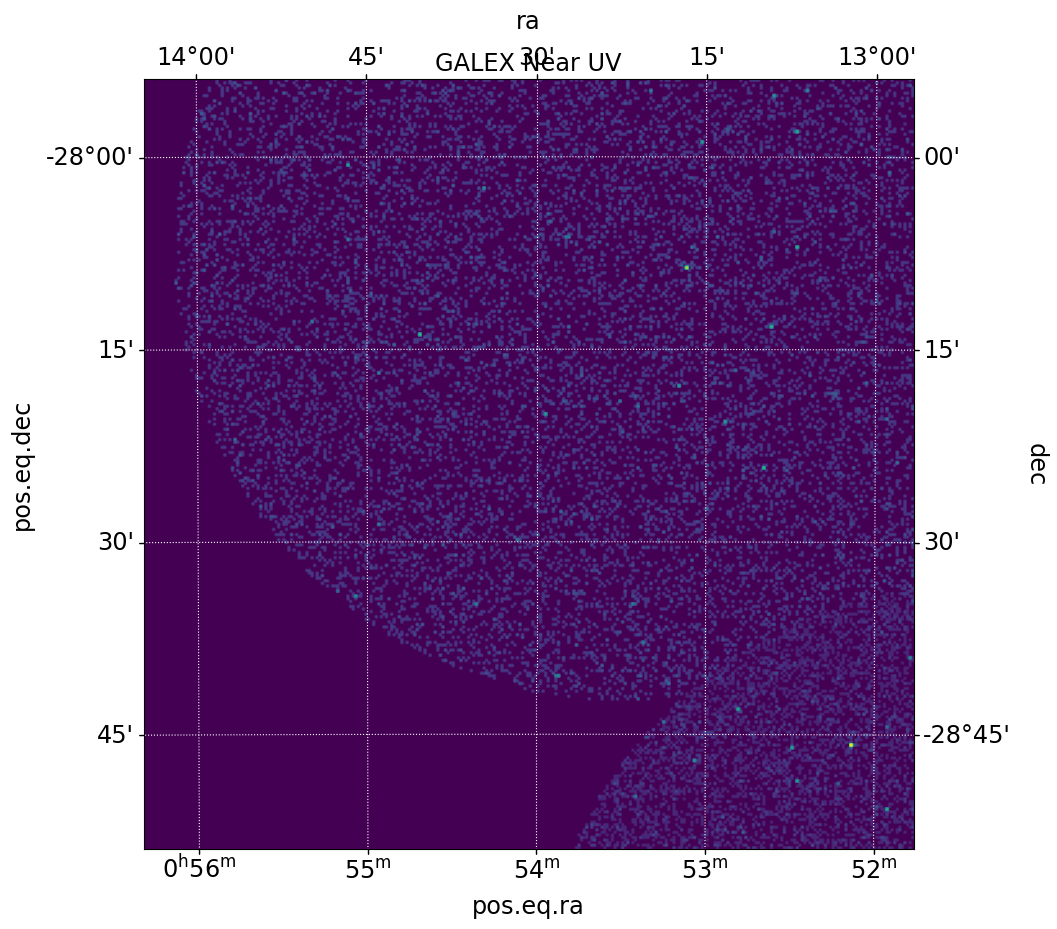

In [49]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
ax.set_title("GALEX Near UV")

Text(0.5, 1.0, 'FORS2 and GALEX Near UV')

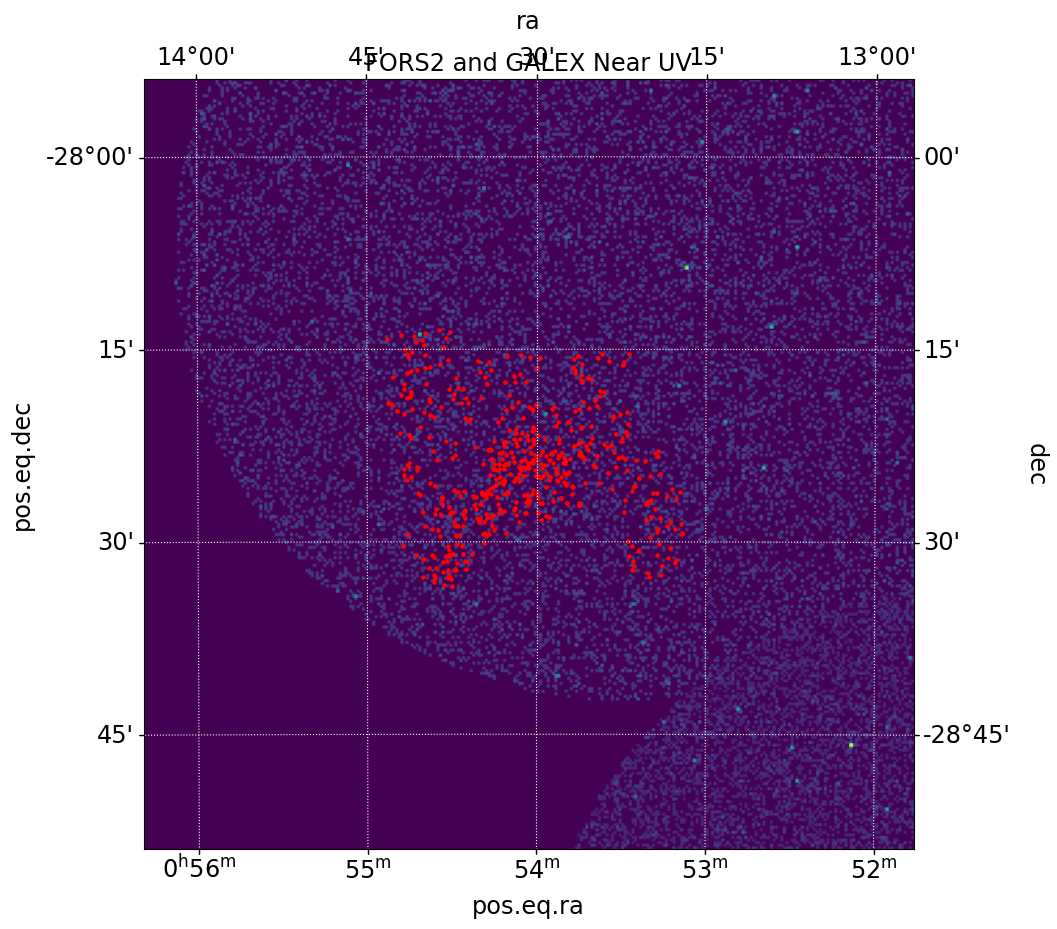

In [50]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=5)
ax.set_title("FORS2 and GALEX Near UV")

Text(0.5, 1.0, 'Galex FUV')

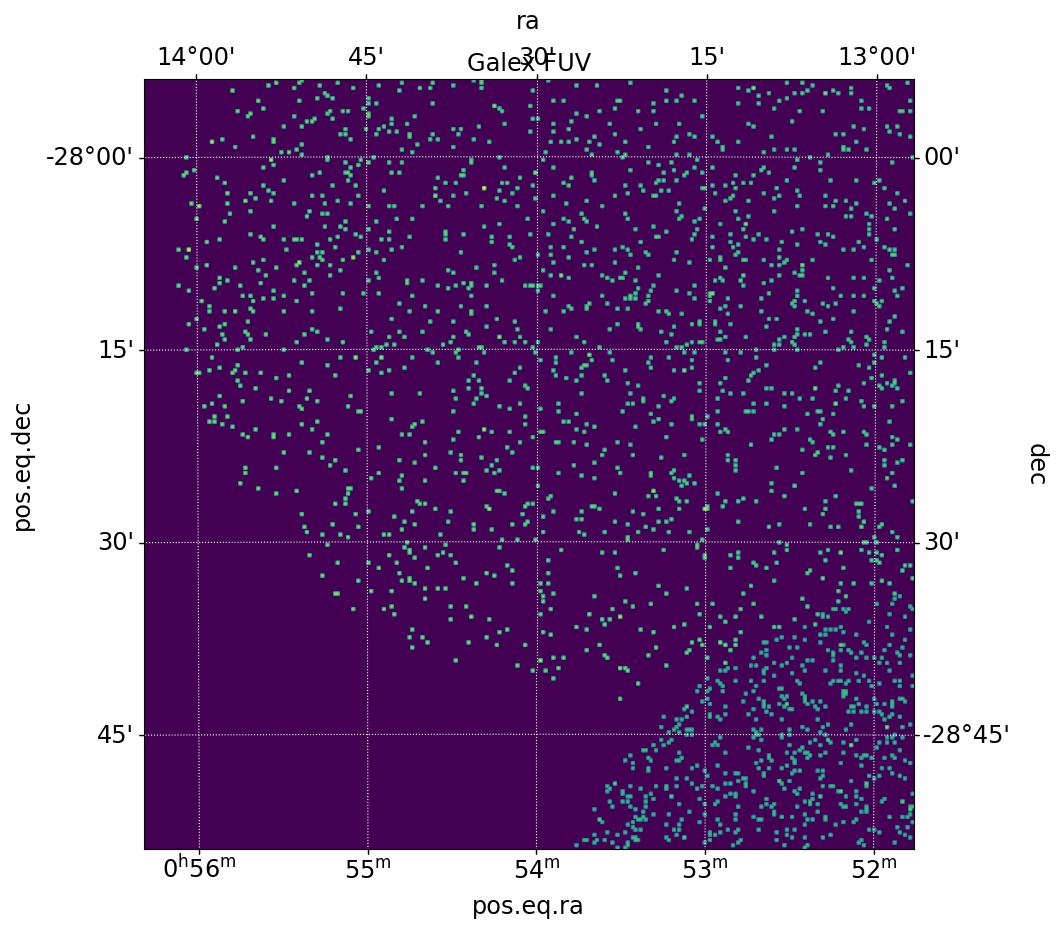

In [51]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['GALEX Far UV'],radius=0.5*u.deg)
the_img = all_img[0]
wcs = WCS(the_img[0].header)
norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())

fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)

ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.set_title("Galex FUV")

Text(0.5, 1.0, 'FORS2 and GALEX Far UV')

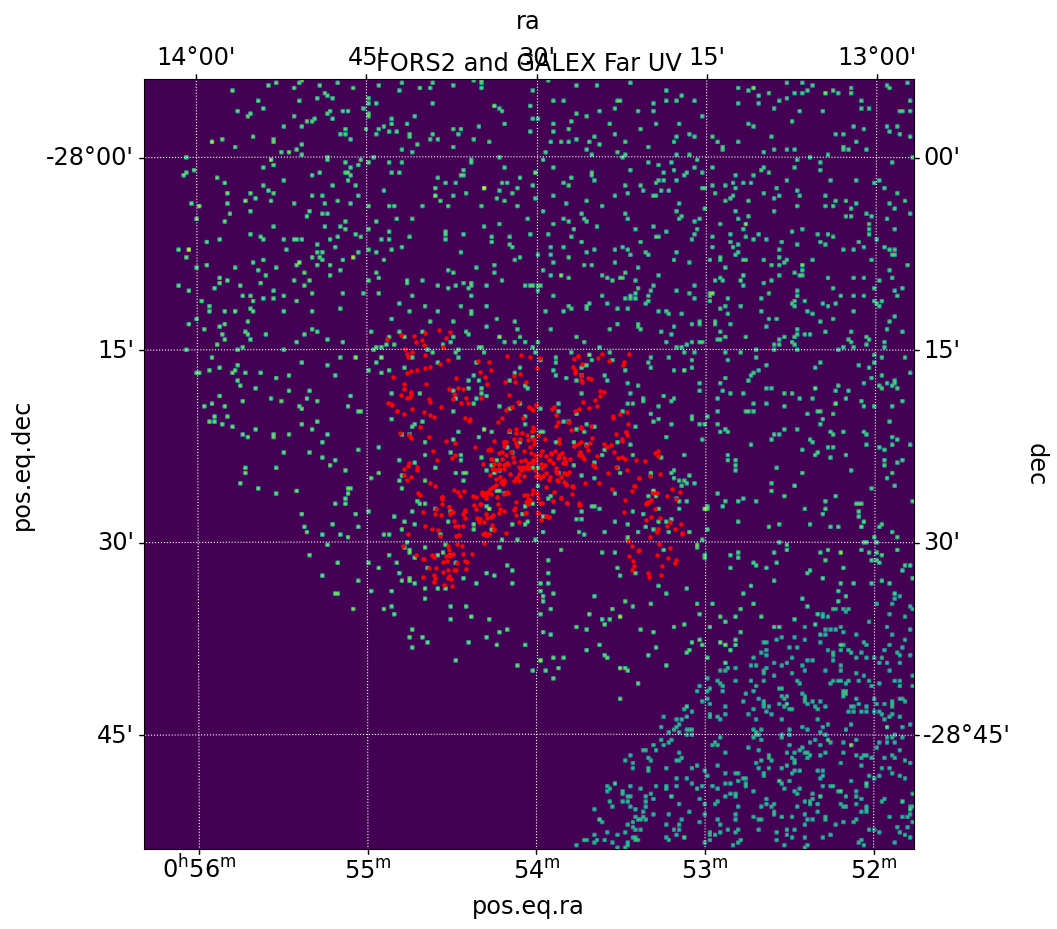

In [52]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')
ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=5)
ax.set_title("FORS2 and GALEX Far UV")

## 2MASS : '2MASS-J', '2MASS-H', '2MASS-K'

In [53]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['2MASS-J'],radius=0.5*u.deg)
the_img = all_img[0]
wcs = WCS(the_img[0].header)
norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())

Text(0.5, 1.0, '2Mass-J')

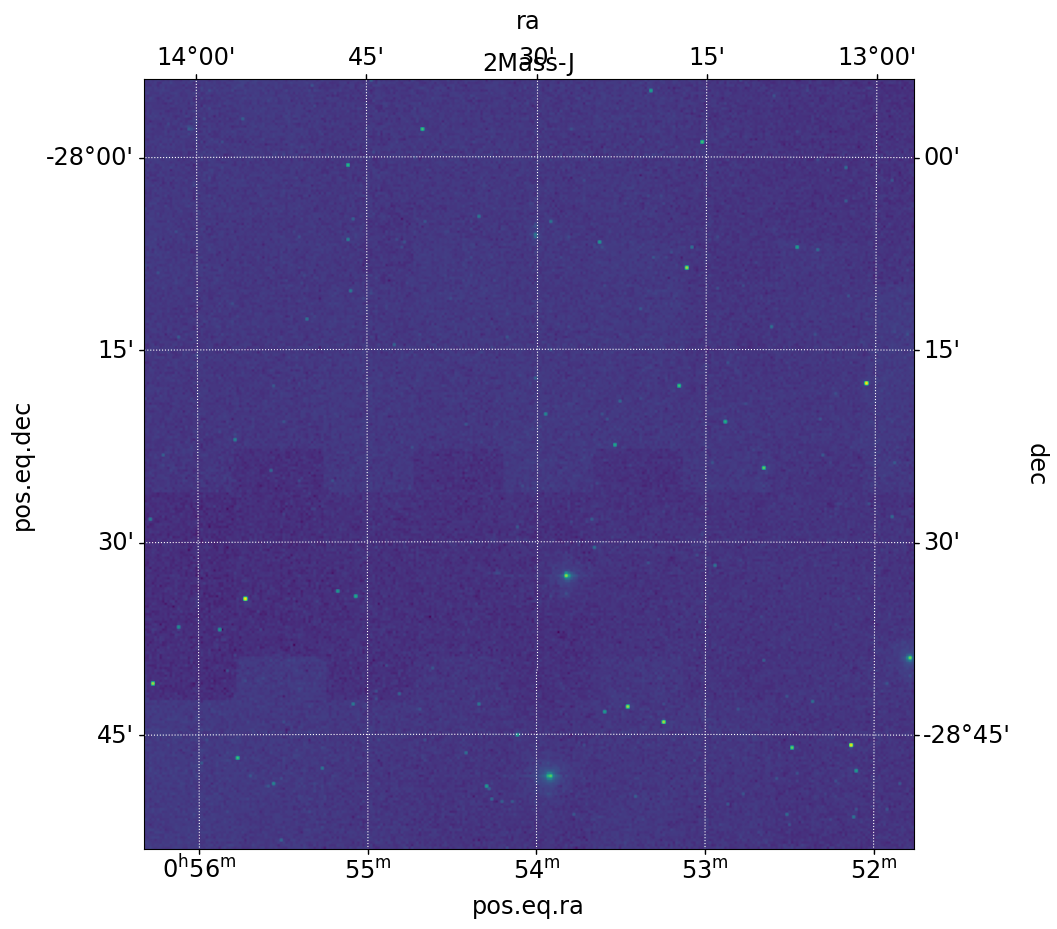

In [54]:
fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)
ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

#ax = fig.add_subplot(2,1,2,projection=wcs)
#ax.imshow(the_img[0].data, origin='lower',norm=norm)
#ax.scatter(ra_toplot.deg, dec_toplot.deg, transform=ax.get_transform('icrs'),c='r',s=5)
#overlay = ax.get_coords_overlay('icrs')
#overlay.grid(color='white', ls='dotted')

ax.set_title("2Mass-J")

Text(0.5, 1.0, '2Mass-H')

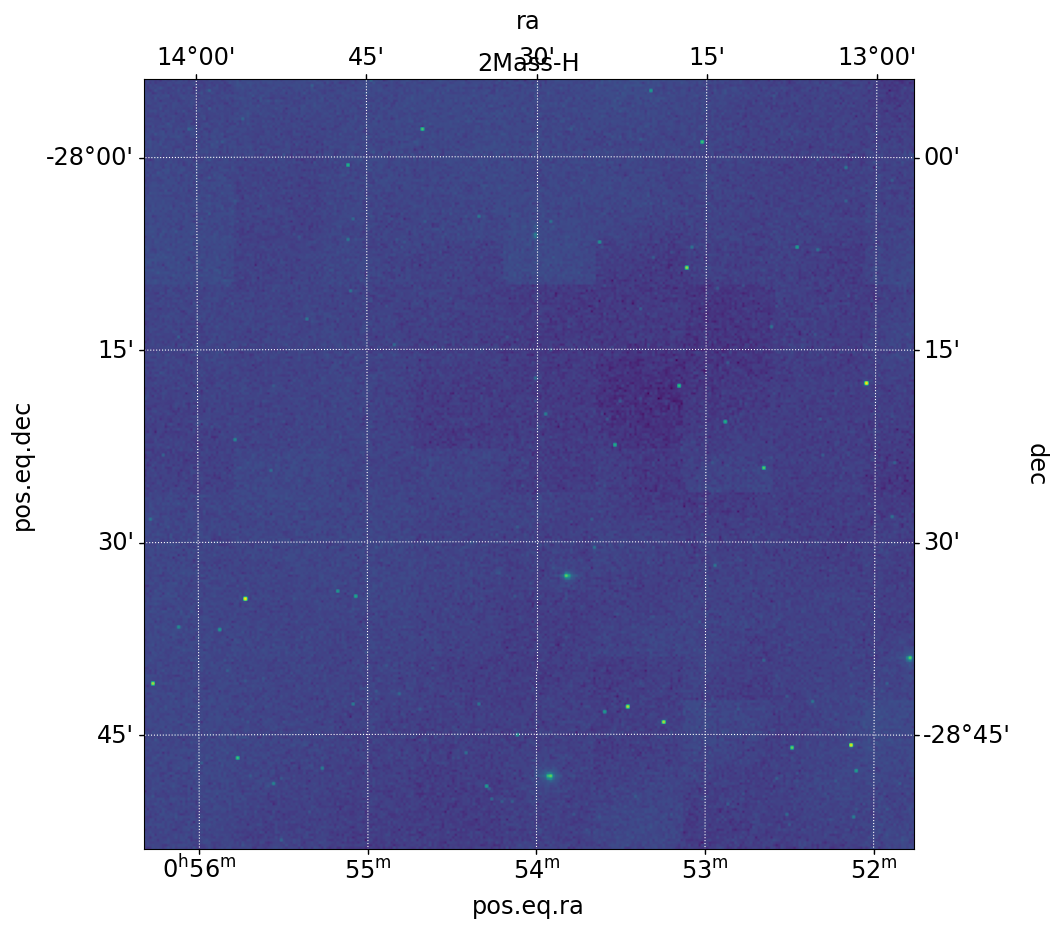

In [55]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['2MASS-H'],radius=0.5*u.deg)
the_img = all_img[0]
wcs = WCS(the_img[0].header)
norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())

fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)

ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.set_title("2Mass-H")

Text(0.5, 1.0, '2Mass-K')

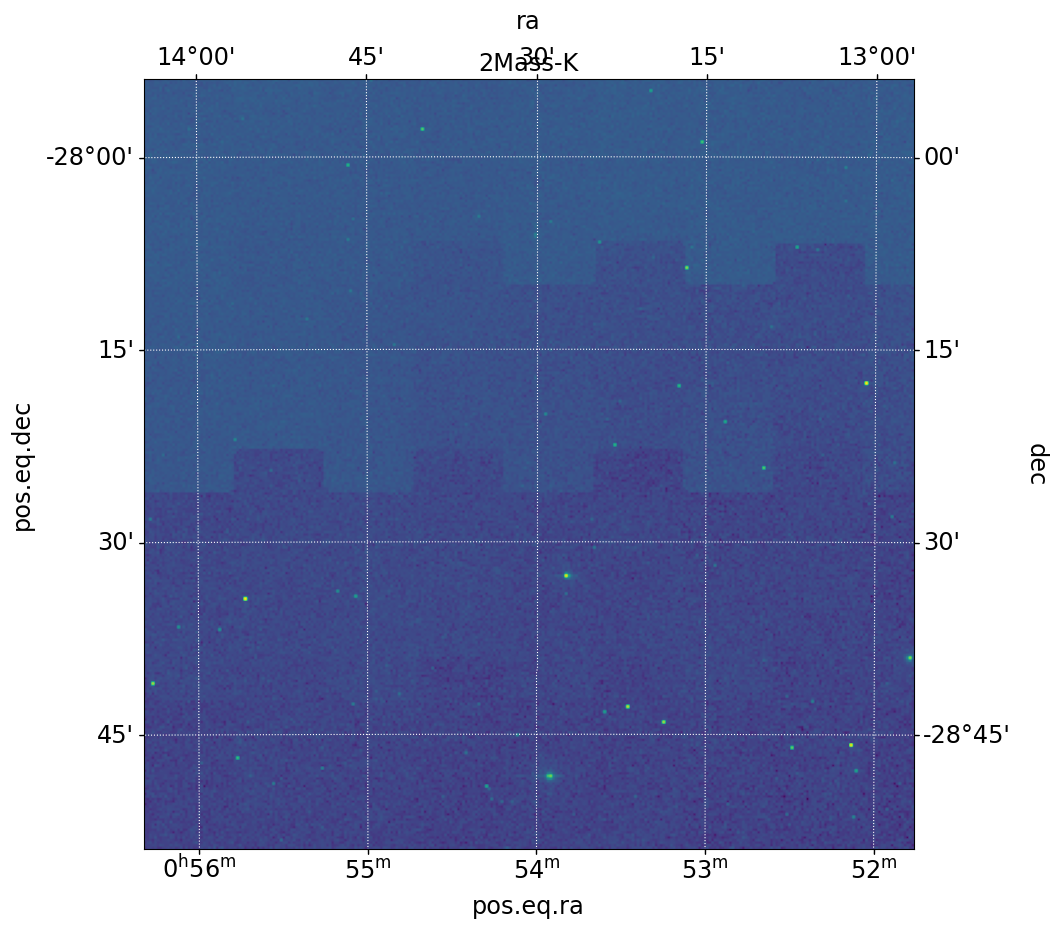

In [56]:
all_img = SkyViewClass().get_images(position='RXJ0054.0-2823',survey=['2MASS-K'],radius=0.5*u.deg)
the_img = all_img[0]
wcs = WCS(the_img[0].header)
norm = ImageNormalize(the_img[0].data, interval = MinMaxInterval(), stretch=LogStretch())

fig=plt.figure(figsize=(10,10))
ax = plt.subplot(projection=wcs)

ax.imshow(the_img[0].data, origin='lower',norm=norm)
overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='white', ls='dotted')

ax.set_title("2Mass-K")

## MAST Missions

In [57]:
ra_angle

<Angle 13.52206487 deg>

In [58]:
dec_angle

<Angle -28.40181098 deg>

In [59]:
from astroquery.mast import MastMissions

missions = MastMissions()

In [60]:
missions.mission

'hst'

# SDSS

https://astroquery.readthedocs.io/en/latest/sdss/sdss.html

In [61]:
coords = coordinates.SkyCoord(df_info.ra.mean(),df_info.dec.mean(), unit="deg")  # defaults to ICRS frame

In [62]:
th1 = (df_info.ra.max()-df_info.ra.min())/2.

In [63]:
th2 = (df_info.dec.max()-df_info.dec.min())/2.

In [64]:
max_radius = Angle(max(th1,th2),u.deg)

In [65]:
max_radius

<Angle 0.217445 deg>

In [66]:
result_spectro = SDSS.query_region(coords,radius = max_radius, spectro=True )
results = SDSS.query_region(coords)

ValueError: radius must be less than 3.0 arcmin.

In [ ]:
coordinates.SkyCoord('0h8m05.63s +14d50m23.3s')

In [ ]:
results = SDSS.query_region(coordinates.SkyCoord('0h8m05.63s +14d50m23.3s'),spectro=True)

In [ ]:
results

In [ ]:
pos = coordinates.SkyCoord('0h8m05.63s +14d50m23.3s', frame='icrs')
xid = SDSS.query_region(pos, radius='5 arcsec', spectro=True)
print(xid)

In [ ]:
redshift = xid['z'][0]
redshift

In [ ]:
sp = SDSS.get_spectra(matches=xid)
im = SDSS.get_images(matches=xid, band='g')

`sp[0]` stores all the files related to the spectra for the object of interest. This is actually an array of several HDU in the FITS format 

The spectrum is stored as a table in the second item of the list. That means that we can get the Table doing the following

In [ ]:
spectra_data = sp[0][1].data

In [ ]:
spectra_data

In [ ]:
spectra_data.shape

In [ ]:
plt.plot(10**spectra_data['loglam'], spectra_data['flux'])
plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (nanomaggies)')
plt.title('SDSS spectra')

In [ ]:
lines = sp[0][3].data

In [ ]:
lines['LINENAME']

In [ ]:
for n in ['[O_II] 3727', '[O_III] 5007', 'H_alpha']:
    print(n, " ->", lines['LINEWAVE'][lines['LINENAME']==n])

In [ ]:
plt.plot(10**spectra_data['loglam']/(1+redshift), spectra_data['flux'], color='black')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_II] 3727'], label=r'O[II]', color='blue')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='[O_III] 5007'], label=r'O[III]', color='red')
plt.axvline(x=lines['LINEWAVE'][lines['LINENAME']=='H_alpha'], label=r'H$\alpha$', color='green')

plt.xlabel('wavelenght (Angstrom)')
plt.ylabel('flux (nanomaggies)')
plt.title('SDSS spectrum')
plt.legend()

In [ ]:
sp[0].info()

In [ ]:
sp[0][2].data

In [ ]:
xid = SDSS.query_region(pos, radius='5 arcmin', spectro=True)

In [ ]:
print(xid)

In [ ]:
sp = SDSS.get_spectra(matches=xid)

In [ ]:
sp[2]